In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multi-label-text-classification/__results__.html
/kaggle/input/multi-label-text-classification/__notebook__.ipynb
/kaggle/input/multi-label-text-classification/__output__.json
/kaggle/input/multi-label-text-classification/custom.css
/kaggle/input/multi-label-text-classification/__results___files/__results___41_1.png
/kaggle/input/multi-label-text-classification/__results___files/__results___89_1.png
/kaggle/input/multi-label-text-classification/__results___files/__results___38_1.png
/kaggle/input/multi-label-text-classification/__results___files/__results___147_0.png
/kaggle/input/multi-label-text-classification/__results___files/__results___163_0.png
/kaggle/input/multi-label-text-classification/__results___files/__results___152_0.png
/kaggle/input/multi-label-text-classification/__results___files/__results___91_0.png
/kaggle/input/multi-label-text-classification/__results___files/__results___146_1.png
/kaggle/input/multi-label-text-classification/__results___files/__res

In [3]:
%pip install contractions --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import kagglehub
import warnings
import os
import re
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import contractions
import xgboost as xgb
import random
import numpy as np
from wordcloud import WordCloud
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier,ClassifierChain
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    hamming_loss, 
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
)

In [5]:
tqdm.pandas()

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
sns.set_theme(style="darkgrid", palette="pastel")

In [9]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [10]:
path = "/kaggle/input/d/hemant2810/multi-label-text-classification"

In [11]:
dtrain = pd.read_csv(os.path.join(path, "train.csv"))
dtest = pd.read_csv(os.path.join(path, "test.csv"))

In [12]:
rows, columns = dtrain.shape
print(f"The train set contains {rows} rows and {columns} columns")

The train set contains 20972 rows and 9 columns


In [13]:
rows, columns = dtest.shape
print(f"The test set contains {rows} rows and {columns} columns")

The test set contains 8989 rows and 3 columns


In [14]:
dtrain.head()

ID                                              TITLE  \
0   1        Reconstructing Subject-Specific Effect Maps   
1   2                 Rotation Invariance Neural Network   
2   3  Spherical polyharmonics and Poisson kernels fo...   
3   4  A finite element approximation for the stochas...   
4   5  Comparative study of Discrete Wavelet Transfor...   

                                            ABSTRACT  Computer Science  \
0    Predictive models allow subject-specific inf...                 1   
1    Rotation invariance and translation invarian...                 1   
2    We introduce and develop the notion of spher...                 0   
3    The stochastic Landau--Lifshitz--Gilbert (LL...                 0   
4    Fourier-transform infra-red (FTIR) spectra o...                 1   

   Physics  Mathematics  Statistics  Quantitative Biology  \
0        0            0           0                     0   
1        0            0           0                     0   
2        0            1           0                     0   
3        0            1           0                     0   
4        0            0           1                     0   

   Quantitative Finance  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [15]:
dtrain.tail()

ID                                              TITLE  \
20967  20968  Contemporary machine learning: a guide for pra...   
20968  20969  Uniform diamond coatings on WC-Co hard alloy c...   
20969  20970  Analysing Soccer Games with Clustering and Con...   
20970  20971  On the Efficient Simulation of the Left-Tail o...   
20971  20972   Why optional stopping is a problem for Bayesians   

                                                ABSTRACT  Computer Science  \
20967    Machine learning is finding increasingly bro...                 1   
20968    Polycrystalline diamond coatings have been g...                 0   
20969    We present a new approach for identifying si...                 1   
20970    The sum of Log-normal variates is encountere...                 0   
20971    Recently, optional stopping has been a subje...                 0   

       Physics  Mathematics  Statistics  Quantitative Biology  \
20967        1            0           0                     0   
20968        1            0           0                     0   
20969        0            0           0                     0   
20970        0            1           1                     0   
20971        0            1           1                     0   

       Quantitative Finance  
20967                     0  
20968                     0  
20969                     0  
20970                     0  
20971                     0

In [16]:
dtrain.describe()

ID  Computer Science       Physics   Mathematics  \
count  20972.000000      20972.000000  20972.000000  20972.000000   
mean   10486.500000          0.409784      0.286716      0.267881   
std     6054.239259          0.491806      0.452238      0.442866   
min        1.000000          0.000000      0.000000      0.000000   
25%     5243.750000          0.000000      0.000000      0.000000   
50%    10486.500000          0.000000      0.000000      0.000000   
75%    15729.250000          1.000000      1.000000      1.000000   
max    20972.000000          1.000000      1.000000      1.000000   

         Statistics  Quantitative Biology  Quantitative Finance  
count  20972.000000          20972.000000          20972.000000  
mean       0.248236              0.027990              0.011873  
std        0.432000              0.164947              0.108317  
min        0.000000              0.000000              0.000000  
25%        0.000000              0.000000              0.000000  
50%        0.000000              0.000000              0.000000  
75%        0.000000              0.000000              0.000000  
max        1.000000              1.000000              1.000000

In [17]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [18]:
dtrain.isna().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [19]:
dtrain.duplicated().sum()

0

In [20]:
ID_COL = "ID"
FEATURES = ["TITLE", "ABSTRACT"]
TARGET_COLS = [col for col in dtrain.columns if col not in [ID_COL] + FEATURES]

In [21]:
TARGET_COLS

['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance']

Text(0.5, 0, 'Labels')

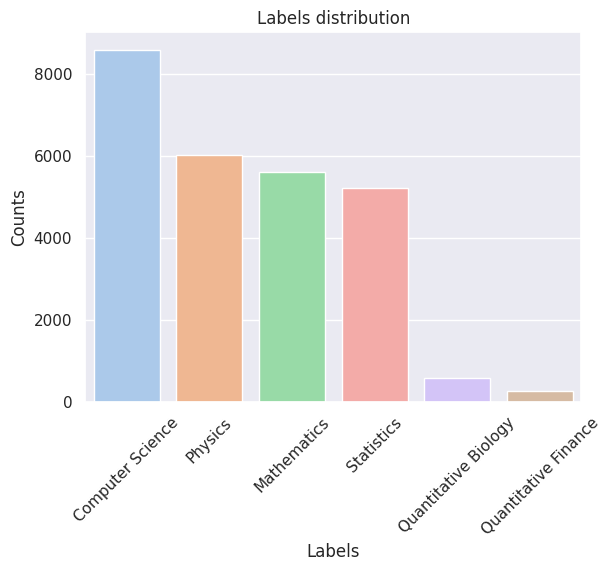

In [22]:
labels_counts = dtrain[TARGET_COLS].sum(axis=0)
labels, counts = labels_counts.index, labels_counts.values
ax = sns.barplot(x=labels, y=counts)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Labels distribution")
ax.set_ylabel("Counts")
ax.set_xlabel("Labels")

In [23]:
labels_counts

Computer Science        8594
Physics                 6013
Mathematics             5618
Statistics              5206
Quantitative Biology     587
Quantitative Finance     249
dtype: int64

<Axes: >

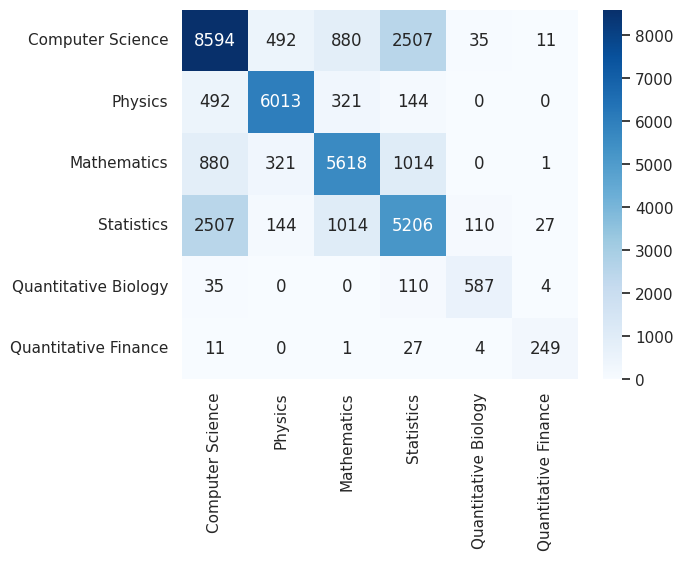

In [24]:
X = dtrain[TARGET_COLS].values
X = X.T @ X
sns.heatmap(X, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

<Axes: >

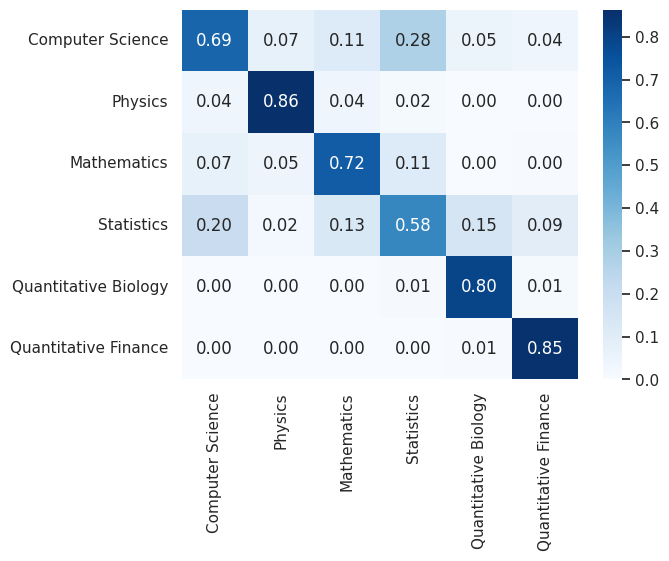

In [25]:
X = X / X.sum(axis=1)
sns.heatmap(X, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)

<Axes: >

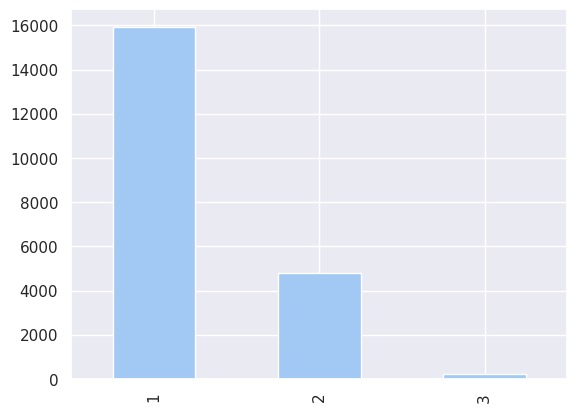

In [26]:
dtrain[TARGET_COLS].sum(axis=1).value_counts().sort_index().plot(kind="bar")

In [27]:
dtrain['title_len'] = dtrain['TITLE'].apply(lambda x: len(x.split()))
dtrain['abstract_len'] = dtrain['ABSTRACT'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='title_len', ylabel='Count'>

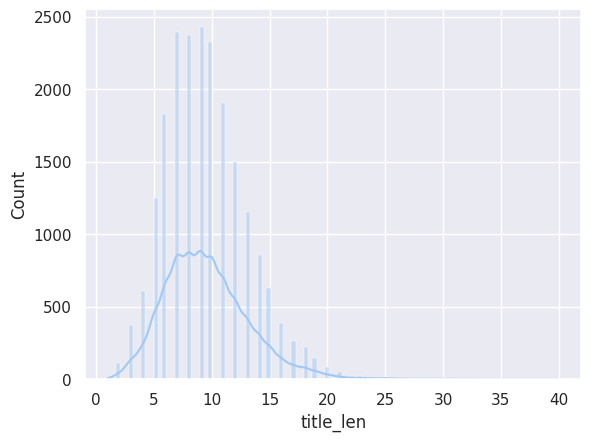

In [28]:
sns.histplot(dtrain['title_len'], kde=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='abstract_len', ylabel='Count'>

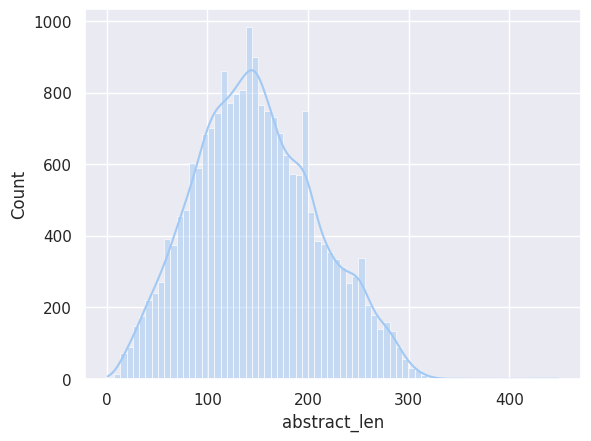

In [29]:
sns.histplot(dtrain['abstract_len'], kde=True)

In [30]:
def plot_wordcloud(
    df : pd.DataFrame,
    label : str,
    ax : plt.Axes = None
) -> plt.Axes:
    
    df = df[df[label] == 1] # Filter rows with the label
    df = df[FEATURES] # Keep only the features columns

    text = df.apply(lambda x: " ".join(x), axis=1).str.cat(sep=" ") # Concatenate the features columns

    wc = WordCloud(width=800, height=400, background_color="black", colormap="viridis").generate(text)

    if ax is None:
        _, ax = plt.subplots()

    ax.imshow(wc)
    ax.axis("off")
    ax.set_title(f"Wordcloud for label: {label}", fontsize=30)

    return ax

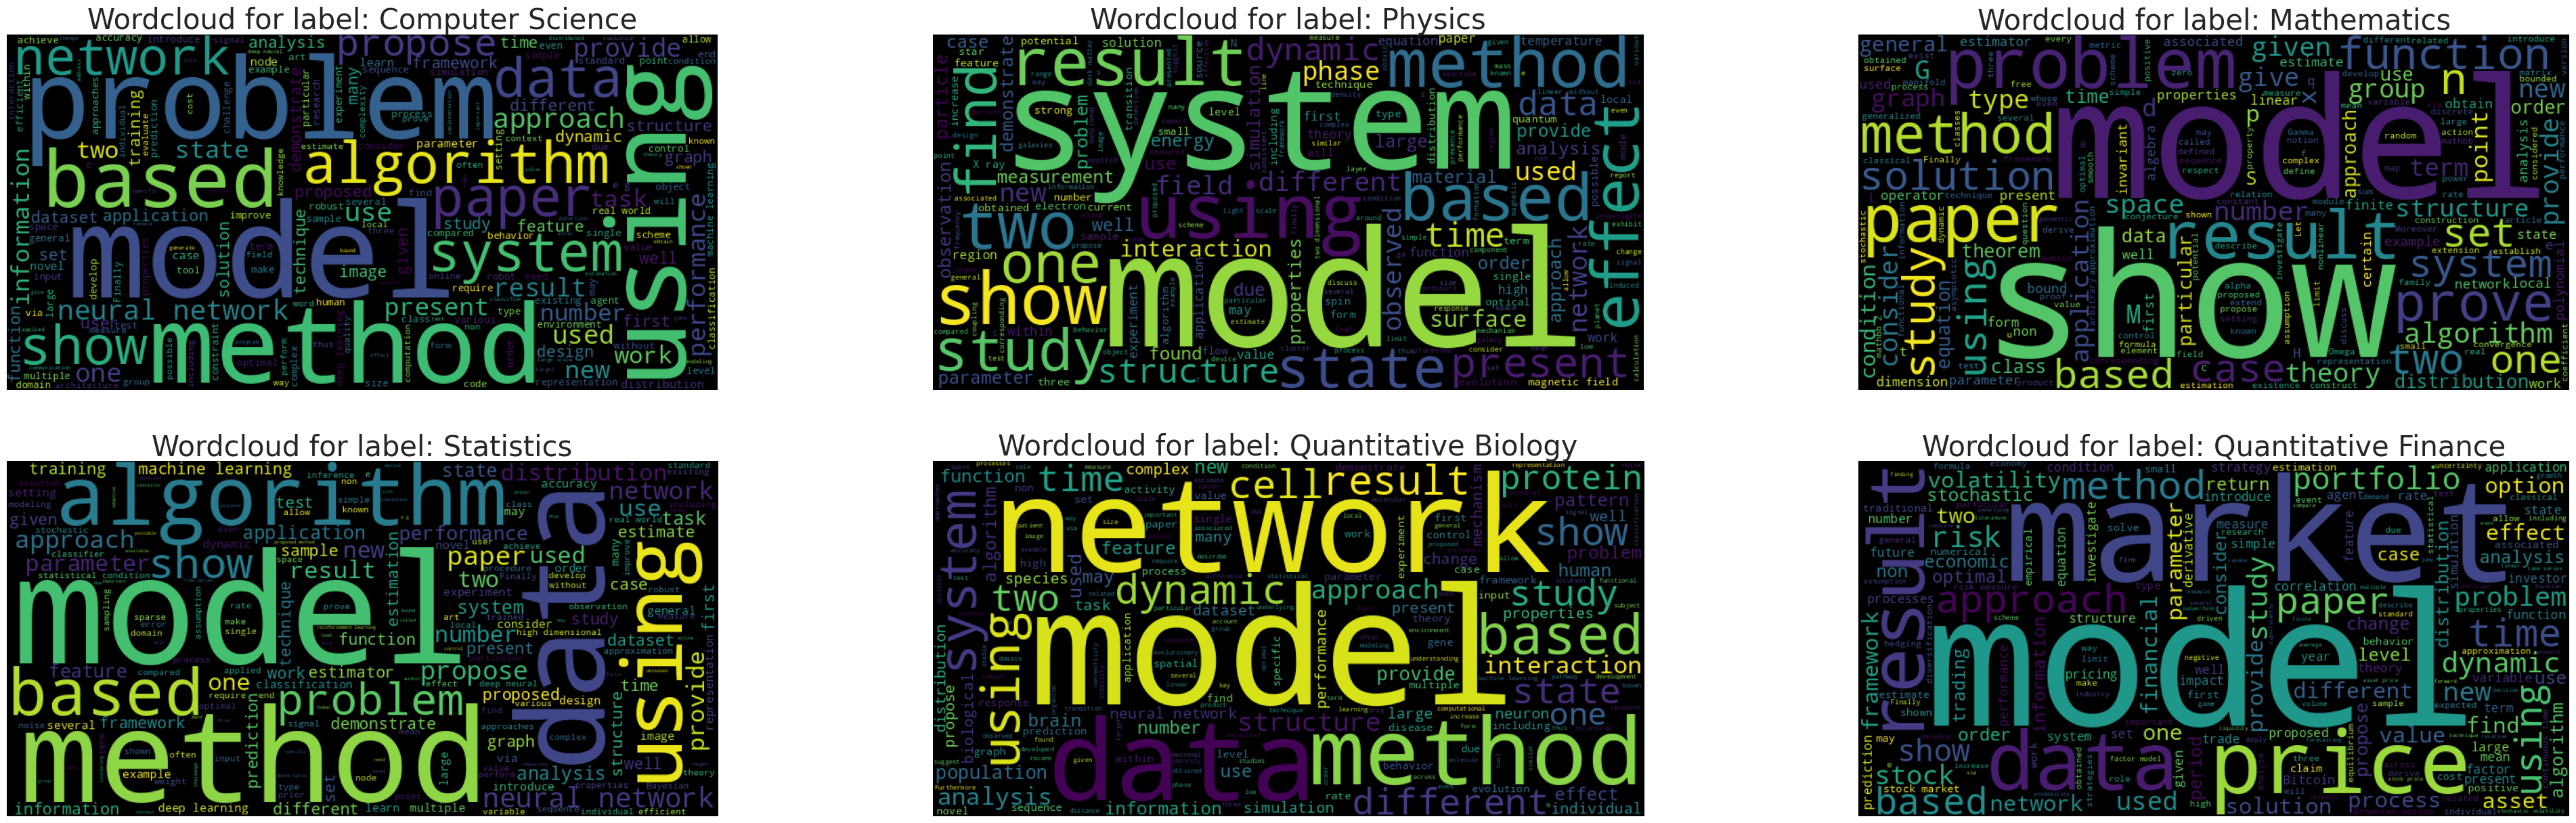

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(50, 15))

i = 0

for row in axes:
    for cell in row:
        label = TARGET_COLS[i]
        plot_wordcloud(dtrain, label, cell)
        i += 1

In [32]:
for title in dtrain['TITLE'].sample(10):
    print(title)

Dynamic Layer Normalization for Adaptive Neural Acoustic Modeling in Speech Recognition
Susceptibility Propagation by Using Diagonal Consistency
The Robot Routing Problem for Collecting Aggregate Stochastic Rewards
Probability, Statistics and Planet Earth, I: Geotemporal covariances
Counting the number of metastable states in the modularity landscape: Algorithmic detectability limit of greedy algorithms in community detection
Sublogarithmic Distributed Algorithms for Lovász Local lemma, and the Complexity Hierarchy
Holography and Koszul duality: the example of the $M2$ brane
Maximal polynomial modulations of singular integrals
PULSEDYN - A dynamical simulation tool for studying strongly nonlinear chains
Variational Bayesian Inference For A Scale Mixture Of Normal Distributions Handling Missing Data


In [33]:
for title in dtrain['ABSTRACT'].sample(10):
    print(title)

  We analyze the clustering problem through a flexible probabilistic model that
aims to identify an optimal partition on the sample X 1 , ..., X n. We perform
exact clustering with high probability using a convex semidefinite estimator
that interprets as a corrected, relaxed version of K-means. The estimator is
analyzed through a non-asymptotic framework and showed to be optimal or
near-optimal in recovering the partition. Furthermore, its performances are
shown to be adaptive to the problem's effective dimension, as well as to K the
unknown number of groups in this partition. We illustrate the method's
performances in comparison to other classical clustering algorithms with
numerical experiments on simulated data.

  The contribution of $O^{2-}$ ions to antiferromagnetism in
$La_{2-x}Ae_xCuO_4$ ($Ae = Sr, Ba)$ is highly sensitive to doped holes. In
contrast, the contribution of $Cu^{2+}$ ions to antiferromagnetism in
$Nd_{2-x}Ce_xCuO_{4+y}$ is much less sensitive to doped electrons. T

In [34]:
class Processor:

    def __init__(self):

        self.stopwords = set(nltk.corpus.stopwords.words("english"))
        self.stemmer = nltk.stem.SnowballStemmer("english")

    def __call__(self, text : str) -> str:

        text = text.lower() # Lowercase
        text = text.replace('-', ' ') # Replace hyphens with spaces
        text = contractions.fix(text) # Expand contractions, for example don't -> do not
        text = re.sub(r"\$.*?\$", "", text) # Replace LaTeX equations
        text = re.sub(r"[^a-zA-Z0-9\s]", " ", text) # Remove special characters
        text = re.sub(r"\d+", " ", text) # Remove digits
        text = re.sub(r"\s+", " ", text) # Remove extra whitespaces
        text = nltk.word_tokenize(text) # Tokenize
        text = [word for word in text if word not in self.stopwords] # Remove stopwords
        text = [self.stemmer.stem(word) for word in text if word] # Stem words
        text = " ".join(text)

        return text

In [35]:
processor = Processor()
processor(dtrain['TITLE'].iloc[9])

'fail predict outbreak potenti presenc natur boost immun'

In [36]:
dtrain['PROCESSED_TITLE'] = dtrain['TITLE'].progress_apply(processor)
dtrain['PROCESSED_ABSTRACT'] = dtrain['ABSTRACT'].progress_apply(processor)
dtrain['PROCESSED_TEXT'] = dtrain['PROCESSED_TITLE'] + " " + dtrain['PROCESSED_ABSTRACT']

  0%|          | 0/20972 [00:00<?, ?it/s]

  0%|          | 0/20972 [00:00<?, ?it/s]

In [37]:
def get_vocab(docs : pd.Series) -> set:

    vocab = set()

    for doc in tqdm(docs):
        vocab.update(doc.split())

    return vocab

In [38]:
vocab = get_vocab(dtrain['PROCESSED_TEXT'])
print(f"The vocabulary contains {len(vocab)} unique words.")

  0%|          | 0/20972 [00:00<?, ?it/s]

The vocabulary contains 35373 unique words.


In [39]:
X = dtrain['PROCESSED_TEXT']
y = dtrain[TARGET_COLS]

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

print(f"Train set contains {len(X_train)} samples")
print(f"Validation set contains {len(X_val)} samples")

Train set contains 14680 samples
Validation set contains 6292 samples


In [41]:
def evaluate_label_wise(
    y_true : pd.DataFrame,
    y_pred : pd.DataFrame,
    metrics : dict
) -> pd.DataFrame:

    results = []

    for label in y_true.columns:

        results.append({})
        
        for metric_name, metric in metrics.items():
            results[-1][metric_name] = metric(y_true[label], y_pred[label])

    results = pd.DataFrame(results, index=y_true.columns)
    results.loc['Mean'] = results.mean(axis=0)  

    return results

In [42]:
def evaluate(
    y_true : pd.DataFrame,
    y_pred : pd.DataFrame,
    metrics : dict
) -> pd.DataFrame:

    results = {}

    for metric_name, metric in metrics.items():
        results[metric_name] = metric(y_true, y_pred)

    return pd.Series(results)

In [43]:
def plot_confusion_matrices(
    y_true : pd.DataFrame,
    y_pred : pd.DataFrame,
): 
    fig, axes = plt.subplots(2, 3, figsize=(9, 5))

    for i, label in enumerate(y_true.columns):
        cm = confusion_matrix(y_true[label], y_pred[label])
        cm = cm / cm.sum(axis=1)[:, None]
        ax = sns.heatmap(cm, ax=axes[i//3, i%3], annot=True, fmt=".2f", cmap="Blues")
        ax.set_title(f"{label}")

    plt.tight_layout()

In [44]:
def plot_results(results : pd.DataFrame) -> None:

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for i,metric in enumerate(results.columns):
        ax = axes[i//2, i%2]
        ax = sns.barplot(data=results, x=results.index, y=metric, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()

    return ax

In [45]:
def plot_cooccurrence_matrix(y : pd.DataFrame) -> None:
    X = y.T @ y
    X = X / X.sum(axis=1)
    sns.heatmap(X, annot=True, fmt=".2f", cmap="Blues", xticklabels=y.columns, yticklabels=y.columns)

In [46]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("svd", TruncatedSVD(n_components=256)),
    ("classifier", MultiOutputClassifier(estimator=xgb.XGBClassifier()))
])

In [47]:
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('svd', TruncatedSVD(n_components=256)),
                ('classifier',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               feature_ty...
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...)))])

In [48]:
y_pred = model.predict(X_val)
y_pred = pd.DataFrame(y_pred, columns=y_val.columns)

In [49]:
metrics = {
    "accuracy" : accuracy_score,
    "precision" : precision_score,
    "recall" : recall_score,
    "f1_macro" : partial(f1_score, average="macro"),
}

In [50]:
moc_results = evaluate_label_wise(y_val, y_pred, metrics)
moc_results

accuracy  precision    recall  f1_macro
Computer Science      0.848379   0.786836  0.845659  0.843326
Physics               0.928322   0.915264  0.830878  0.910700
Mathematics           0.897807   0.847755  0.761098  0.866606
Statistics            0.879212   0.759234  0.731225  0.832916
Quantitative Biology  0.972505   0.666667  0.188482  0.639928
Quantitative Finance  0.991259   0.810811  0.384615  0.758664
Mean                  0.919580   0.797761  0.623660  0.808690

<Axes: ylabel='f1_macro'>

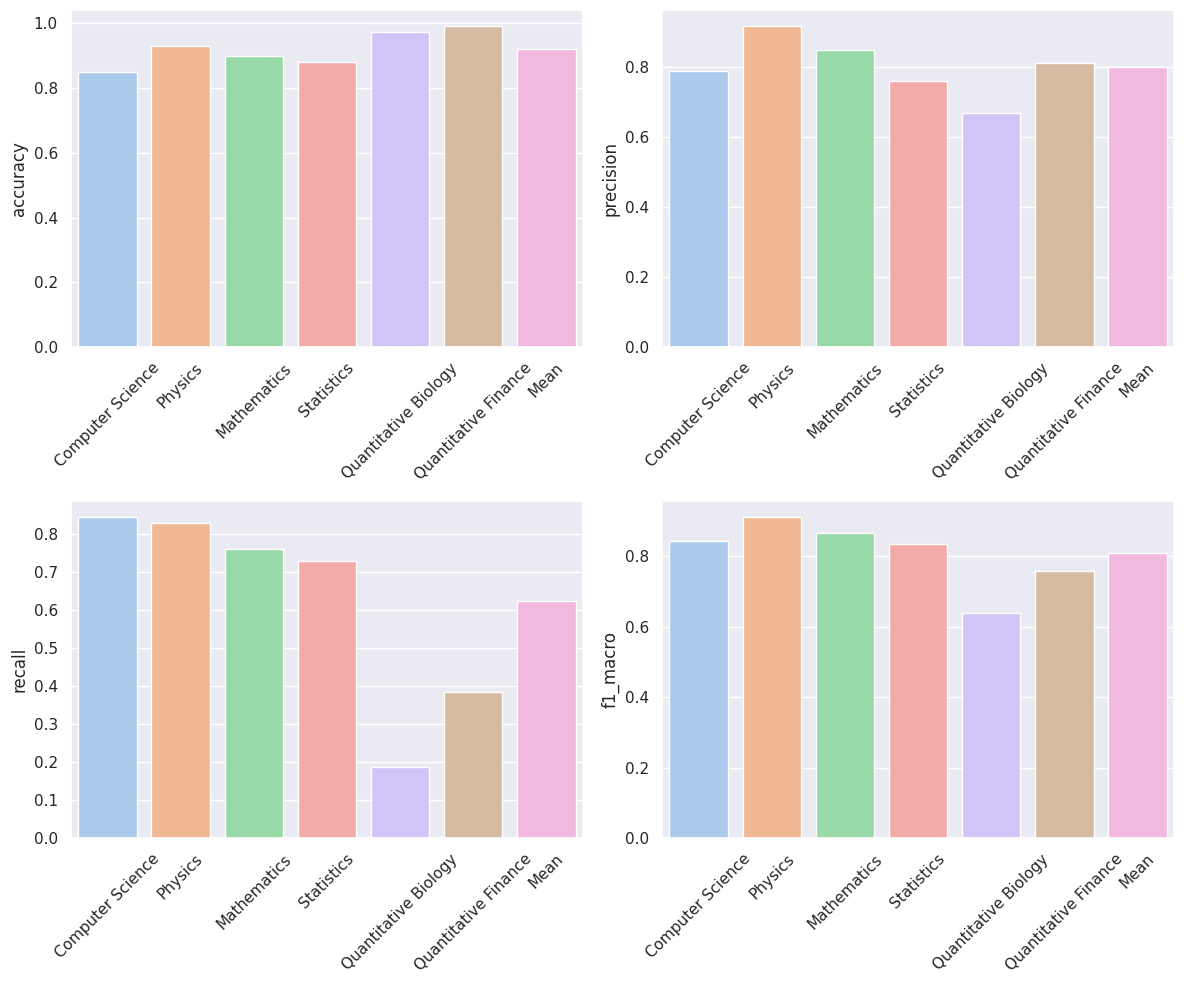

In [51]:
plot_results(moc_results)

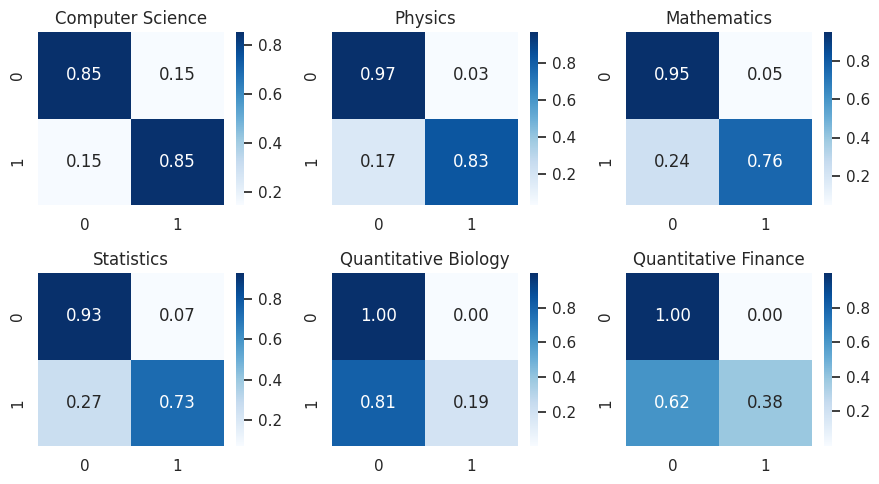

In [52]:
plot_confusion_matrices(y_val, y_pred)

In [53]:
moc_results_2 = evaluate(y_val, y_pred, {
    "hamming_loss" : hamming_loss,
    "accuracy" : accuracy_score,
    "f1_macro" : partial(f1_score, average="macro"),
})

moc_results_2

hamming_loss    0.080420
accuracy        0.649078
f1_macro        0.674816
dtype: float64

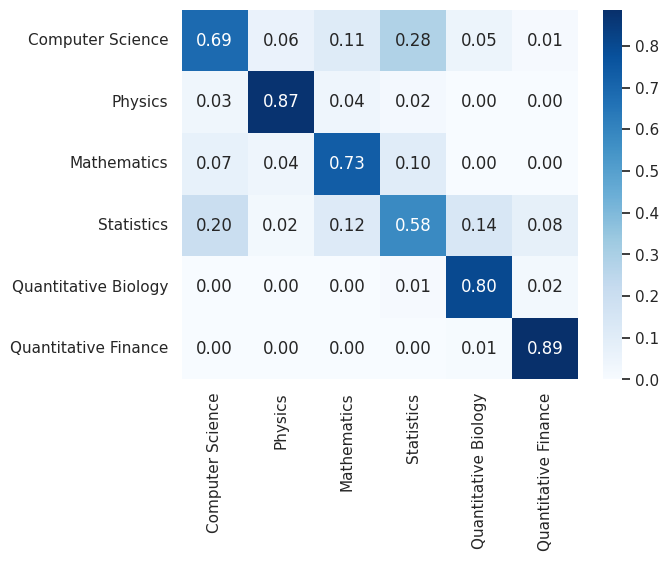

In [54]:
plot_cooccurrence_matrix(y_val)

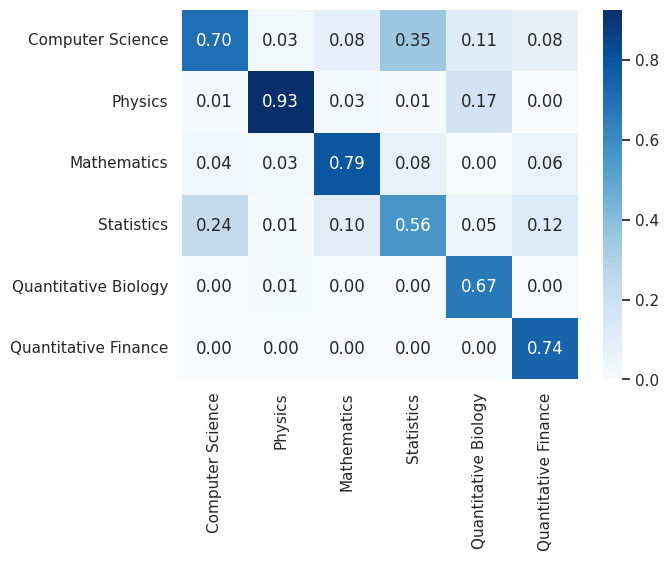

In [55]:
plot_cooccurrence_matrix(y_pred)

In [56]:
order = ['Physics', 'Computer Science', 'Statistics','Mathematics','Quantitative Biology', 'Quantitative Finance']

In [57]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("svd", TruncatedSVD(n_components=256)),
    ("classifier", ClassifierChain(
        base_estimator=xgb.XGBClassifier(),
        order=[TARGET_COLS.index(label) for label in order],
    ))
])

In [58]:
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('svd', TruncatedSVD(n_components=256)),
                ('classifier',
                 ClassifierChain(base_estimator=XGBClassifier(base_score=None,
                                                              booster=None,
                                                              callbacks=None,
                                                              colsample_bylevel=None,
                                                              colsample_bynode=None,
                                                              colsample_bytree=None,
                                                              device=None,
                                                              early_stopping_rounds=None,
                                                              enable_categorical=False,
                                                              eval_metric=None,
                                                              feature_typ...
                                                              importance_type=None,
                                                              interaction_constraints=None,
                                                              learning_rate=None,
                                                              max_bin=None,
                                                              max_cat_threshold=None,
                                                              max_cat_to_onehot=None,
                                                              max_delta_step=None,
                                                              max_depth=None,
                                                              max_leaves=None,
                                                              min_child_weight=None,
                                                              missing=nan,
                                                              monotone_constraints=None,
                                                              multi_strategy=None,
                                                              n_estimators=None,
                                                              n_jobs=None,
                                                              num_parallel_tree=None,
                                                              random_state=None, ...),
                                 order=[1, 0, 3, 2, 4, 5]))])

In [59]:
y_pred = model.predict(X_val)
y_pred = pd.DataFrame(y_pred, columns=y_val.columns)

In [60]:
cc_results = evaluate_label_wise(y_val, y_pred, metrics)
cc_results

accuracy  precision    recall  f1_macro
Computer Science      0.856961   0.793205  0.863344  0.852485
Physics               0.929593   0.919686  0.830878  0.912161
Mathematics           0.900032   0.858372  0.757593  0.868823
Statistics            0.876987   0.771137  0.696970  0.826168
Quantitative Biology  0.970915   0.541667  0.272251  0.673744
Quantitative Finance  0.990464   0.725000  0.371795  0.743356
Mean                  0.920825   0.768178  0.632139  0.812790

<Axes: ylabel='f1_macro'>

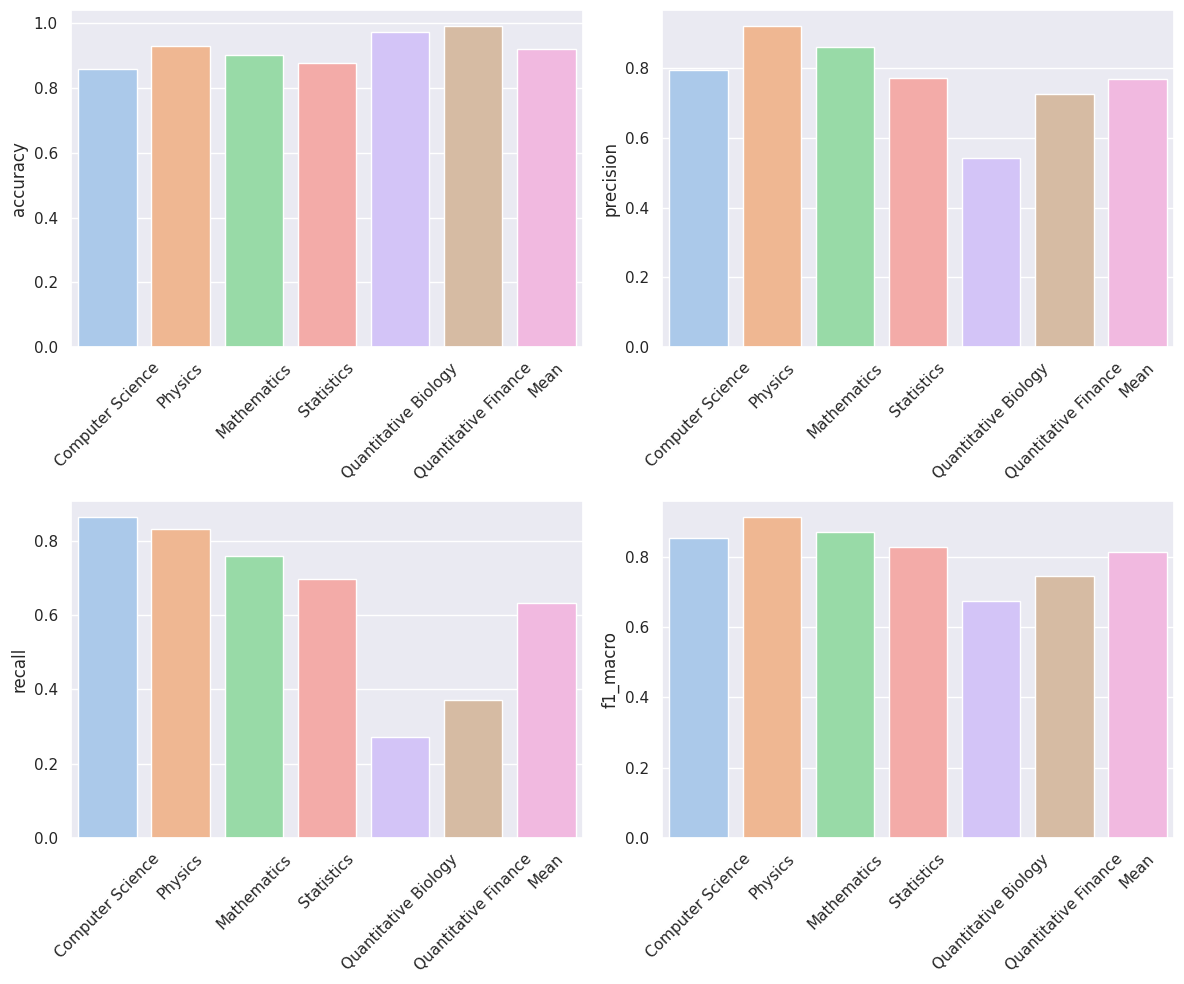

In [61]:
plot_results(cc_results)

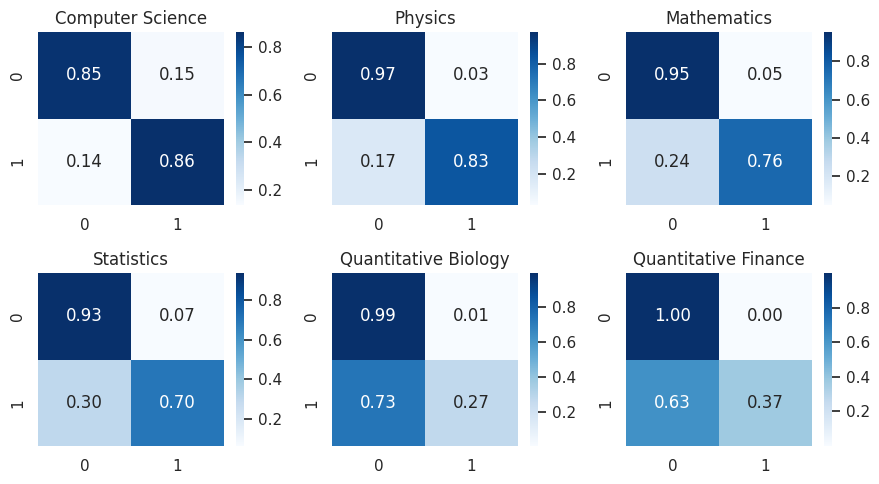

In [62]:
plot_confusion_matrices(y_val, y_pred)

In [63]:
cc_results_2 = evaluate(y_val, y_pred, {
    "hamming_loss" : hamming_loss,
    "accuracy" : accuracy_score,
    "f1_macro" : partial(f1_score, average="macro"),
})

cc_results_2

hamming_loss    0.079175
accuracy        0.674984
f1_macro        0.681789
dtype: float64

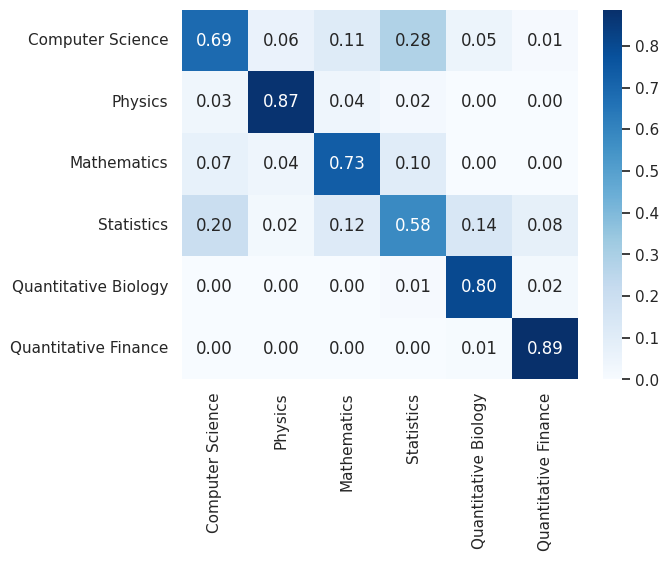

In [64]:
plot_cooccurrence_matrix(y_val)

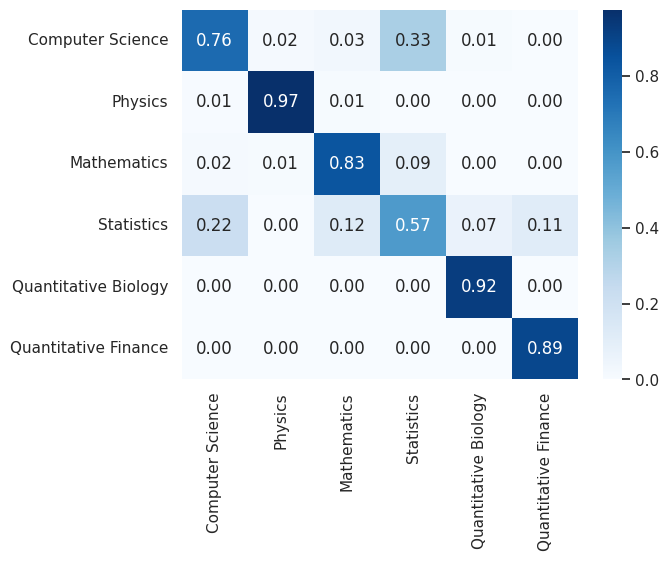

In [65]:
plot_cooccurrence_matrix(y_pred)

In [66]:
def irpl(y : pd.DataFrame) -> pd.Series:
    labels_count = y.sum(axis=0)
    return labels_count.max() / labels_count

In [67]:
irpls = irpl(y_train)
print(irpls)

Computer Science         1.000000
Physics                  1.460766
Mathematics              1.563236
Statistics               1.655640
Quantitative Biology    15.419192
Quantitative Finance    35.707602
dtype: float64


In [68]:
tail_labels = irpls.index[irpls > irpls.mean()]
print(tail_labels)

Index(['Quantitative Biology', 'Quantitative Finance'], dtype='object')


In [69]:
class MLSMOTE:

    def __init__(self,
        n_neighbors : int = 5,
        alpha_scale : float = 0.25,
    ) -> None:
        
        self.irpls = None
        self.tail_labels = None
        self.nn = None
        self.labels_count = None

        self.n_neighbors = n_neighbors
        self.alpha_scale = alpha_scale

    def _irpl(self, y : pd.DataFrame) -> pd.Series:
        labels_count = y.sum(axis=0)
        return labels_count.max() / labels_count
    
    def _tail_labels(self, y : pd.DataFrame) -> list[str]:
        irpls = self._irpl(y)
        return irpls.index[irpls > irpls.mean()].to_list()
    
    def _labels_count(self) -> dict:

        irpls = self.irpls
        p = irpls / irpls.sum()
        p = p ** -self.alpha_scale
        p = p / p.sum()
        p = p * len(y)
        p = p.astype(int)
        p = p[self.tail_labels].to_dict()

        return p

    def fit_resample(self, X : pd.DataFrame, y : pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        
        ### Compute the IRPL for each label
        irpls = self._irpl(y)
        self.irpls = irpls

        ### Get the tail labels
        tail_labels = self._tail_labels(y)
        self.tail_labels = tail_labels

        ### Calculate the number of synthetic samples to generate for each tail label
        labels_count = self._labels_count()
        self.labels_count = labels_count

        ### Restrict X and y to instances with tail labels
        index = X.index[y[tail_labels].sum(axis=1) > 0]
        subset_X = X.loc[index].reset_index(drop=True)
        subset_y = y.loc[index].reset_index(drop=True)

        ### Get the neighbors for each sample in the subset
        nn = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.nn = nn.fit(X)
        neighbors = nn.kneighbors(subset_X, return_distance=False)

        ### Generate synthetic samples
        X_synth = [X]
        y_synth = [y]

        for tail_label, count in labels_count.items():
            
            # 1- Pick random reference samples
            indices = np.arange(len(subset_X))
            indices = indices[subset_y[tail_label] == 1]
            reference_indices = np.random.choice(indices, count)

            # 2- Pick random neighbors of the reference samples
            random_neighbors = np.random.randint(1, self.n_neighbors, count)
            random_neighbors = neighbors[reference_indices, random_neighbors]

            # 3- Compute the difference between the reference samples and their neighbors
            gap = subset_X.iloc[reference_indices].values - X.iloc[random_neighbors].values

            # 4- Compute the synthetic samples features X
            ratio = np.random.rand(count, 1)
            X_new = subset_X.loc[reference_indices].values + ratio * gap
            X_new = pd.DataFrame(X_new, columns=subset_X.columns)

            # 5- Compute the synthetic samples labels y
            y_new = y.values[neighbors[reference_indices,:].flatten()]
            y_new = y_new.reshape(count, self.n_neighbors, subset_y.shape[1])
            y_new = y_new.sum(axis=1) > 0
            y_new = y_new.astype(int)
            y_new = pd.DataFrame(y_new, columns=subset_y.columns)

            # 6- Append the synthetic samples to the original dataset
            X_synth.append(X_new)
            y_synth.append(y_new)

        X_synth = pd.concat(X_synth)
        y_synth = pd.concat(y_synth)

        return X_synth, y_synth

In [70]:
feature_extractor = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("svd", TruncatedSVD(n_components=256)),
])

In [71]:
X_train_features = feature_extractor.fit_transform(X_train)
X_val_features = feature_extractor.transform(X_val)

In [72]:
mlsmote = MLSMOTE(alpha_scale=0.1)
X_train_resampled, y_train_resampled = mlsmote.fit_resample(pd.DataFrame(X_train_features, index=y_train.index), y_train)

In [73]:
print(f"Train set contains {len(X_train_resampled)} samples")

Train set contains 20423 samples


In [74]:
print(y_train_resampled.sum())

Computer Science        9642
Physics                 7036
Mathematics             5701
Statistics              6611
Quantitative Biology    3870
Quantitative Finance    3118
dtype: int64


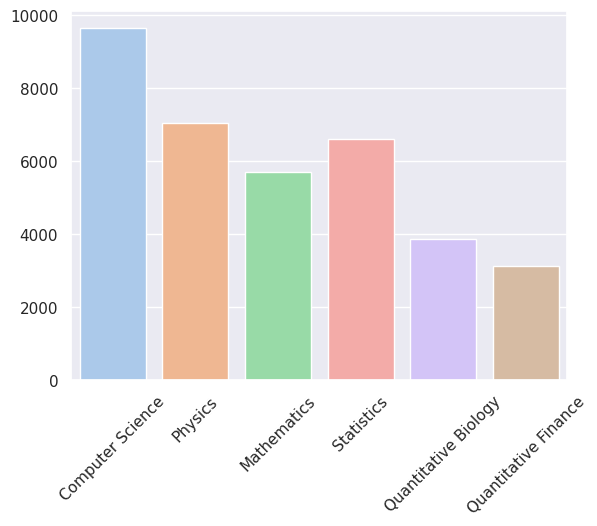

In [75]:
ax = sns.barplot(x=y_train_resampled.columns, y=y_train_resampled.sum())
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [76]:
irpls = irpl(y_train_resampled)
print(irpls)

Computer Science        1.000000
Physics                 1.370381
Mathematics             1.691282
Statistics              1.458478
Quantitative Biology    2.491473
Quantitative Finance    3.092367
dtype: float64


In [77]:
model = MultiOutputClassifier(estimator=xgb.XGBClassifier())

In [78]:
model.fit(X_train_resampled, y_train_resampled)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

In [79]:
y_pred = model.predict(X_val_features)
y_pred = pd.DataFrame(y_pred, columns=y_val.columns)

In [80]:
mlsmote_results = evaluate_label_wise(y_val, y_pred, metrics)
mlsmote_results

accuracy  precision    recall  f1_macro
Computer Science      0.848697   0.780292  0.859325  0.844243
Physics               0.924984   0.896793  0.839062  0.907366
Mathematics           0.895264   0.837716  0.762850  0.863886
Statistics            0.880324   0.762166  0.732543  0.834340
Quantitative Biology  0.972823   0.628205  0.256545  0.675213
Quantitative Finance  0.991100   0.761905  0.410256  0.764420
Mean                  0.918865   0.777846  0.643430  0.814911

<Axes: ylabel='f1_macro'>

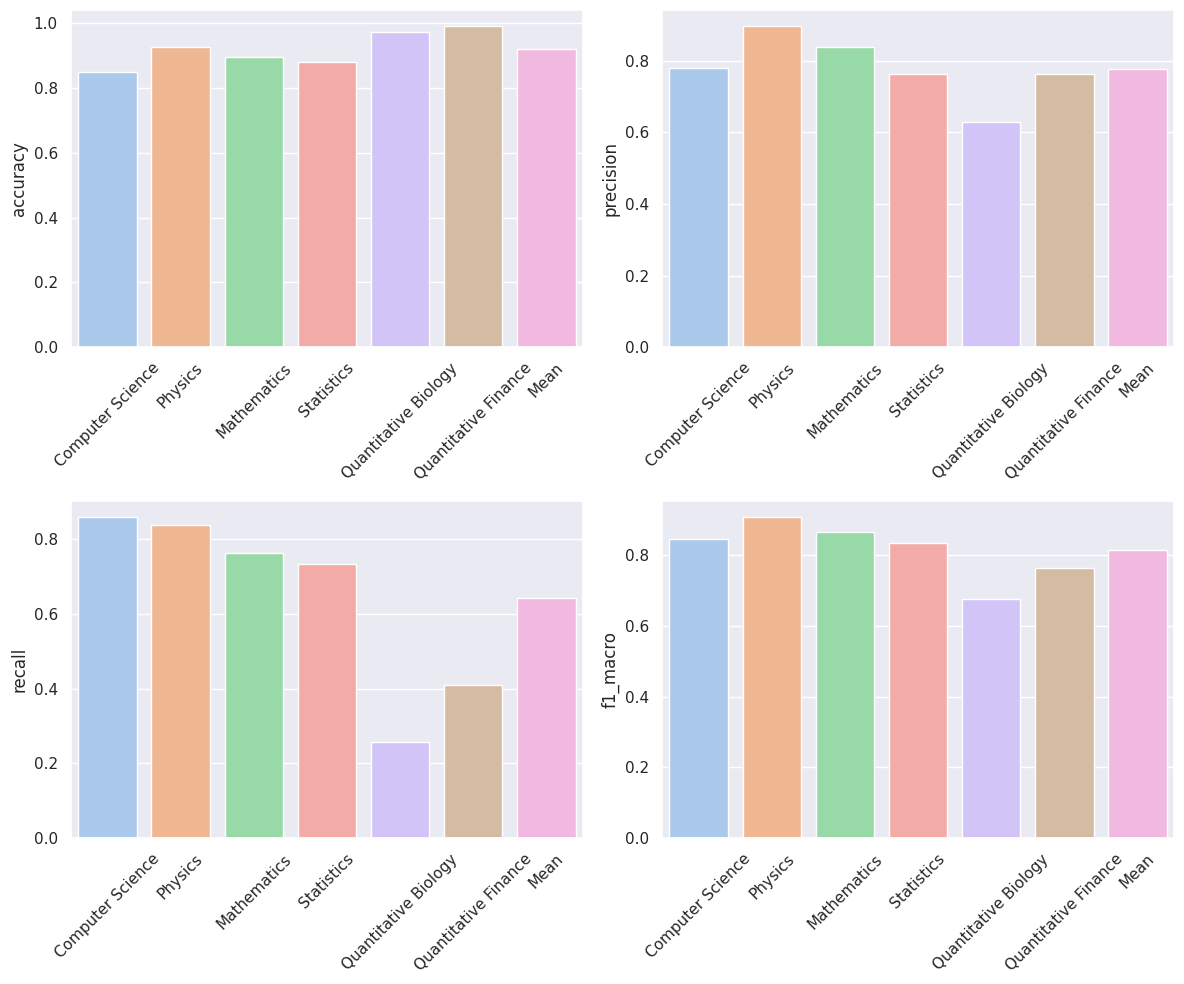

In [81]:
plot_results(mlsmote_results)

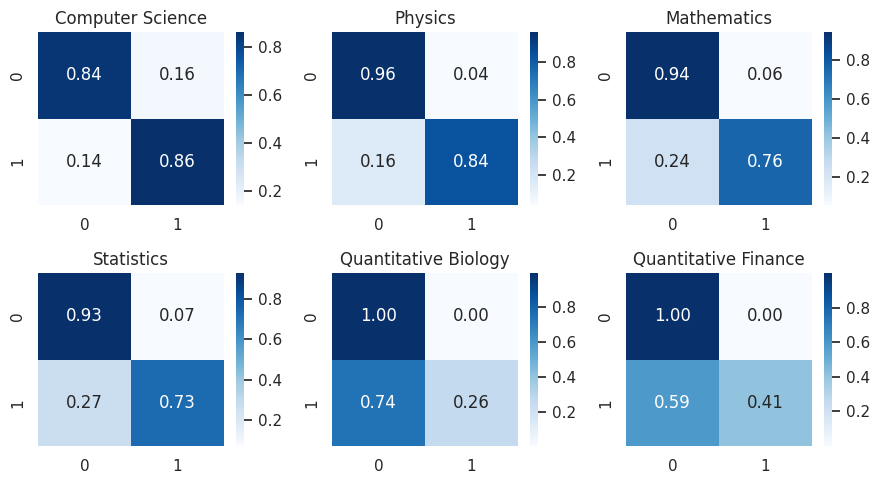

In [82]:
plot_confusion_matrices(y_val, y_pred)

In [83]:
mlsmote_results_2 = evaluate(y_val, y_pred, {
    "hamming_loss" : hamming_loss,
    "accuracy" : accuracy_score,
    "f1_macro" : partial(f1_score, average="macro"),
})

mlsmote_results_2

hamming_loss    0.081135
accuracy        0.645423
f1_macro        0.688018
dtype: float64

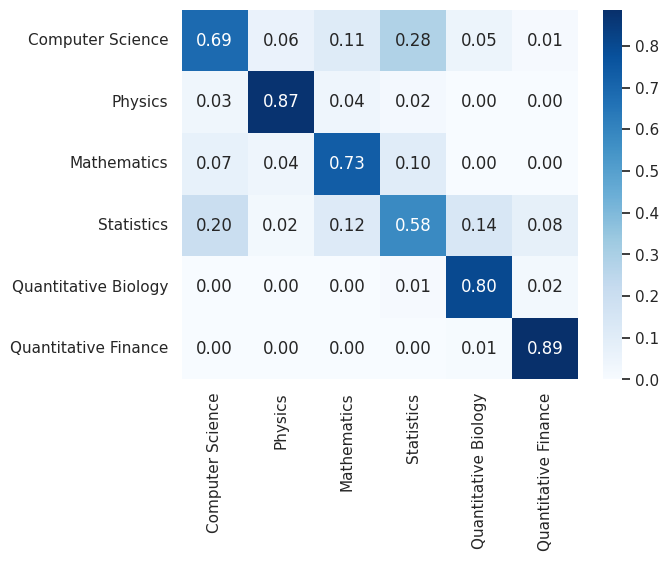

In [84]:
plot_cooccurrence_matrix(y_val)

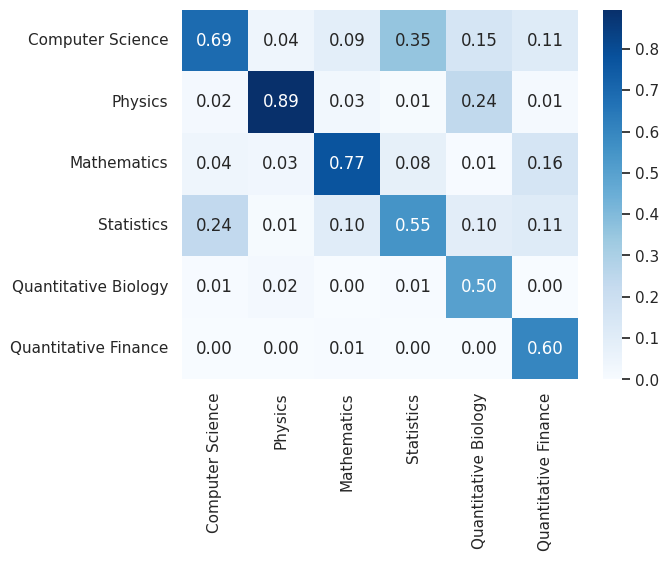

In [85]:
plot_cooccurrence_matrix(y_pred)

In [86]:
cc_results['type'] = 'ClassifierChain'
moc_results['type'] = 'MultiOutputClassifier'
mlsmote_results['type'] = 'MOC_MLSMOTE'

results = pd.concat([cc_results, moc_results, mlsmote_results])
results.head()

accuracy  precision    recall  f1_macro             type
Computer Science      0.856961   0.793205  0.863344  0.852485  ClassifierChain
Physics               0.929593   0.919686  0.830878  0.912161  ClassifierChain
Mathematics           0.900032   0.858372  0.757593  0.868823  ClassifierChain
Statistics            0.876987   0.771137  0.696970  0.826168  ClassifierChain
Quantitative Biology  0.970915   0.541667  0.272251  0.673744  ClassifierChain

In [87]:
means = results[results.index == 'Mean']
means

accuracy  precision    recall  f1_macro                   type
Mean  0.920825   0.768178  0.632139  0.812790        ClassifierChain
Mean  0.919580   0.797761  0.623660  0.808690  MultiOutputClassifier
Mean  0.918865   0.777846  0.643430  0.814911            MOC_MLSMOTE

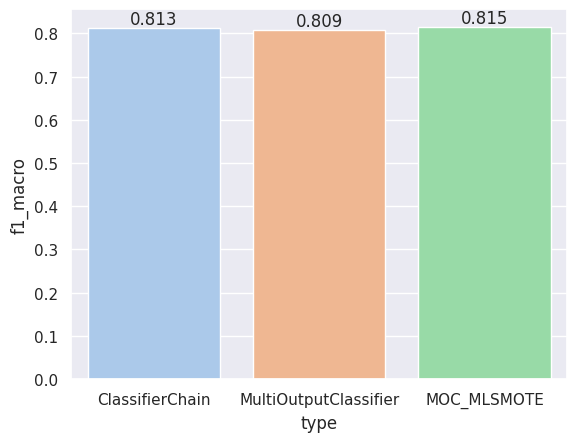

In [88]:
ax = sns.barplot(data=means, x="type", y="f1_macro")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

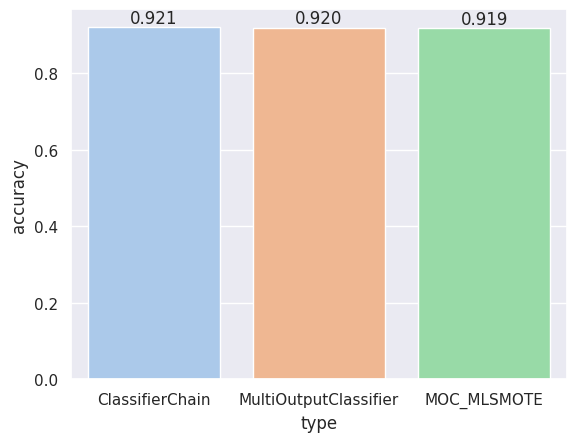

In [89]:
ax = sns.barplot(data=means, x="type", y="accuracy")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

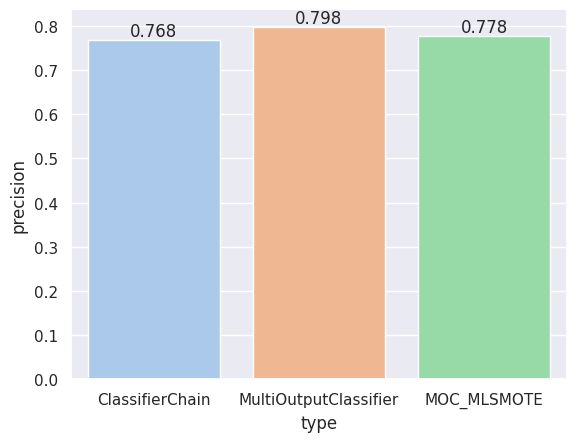

In [90]:
ax = sns.barplot(data=means, x="type", y="precision")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

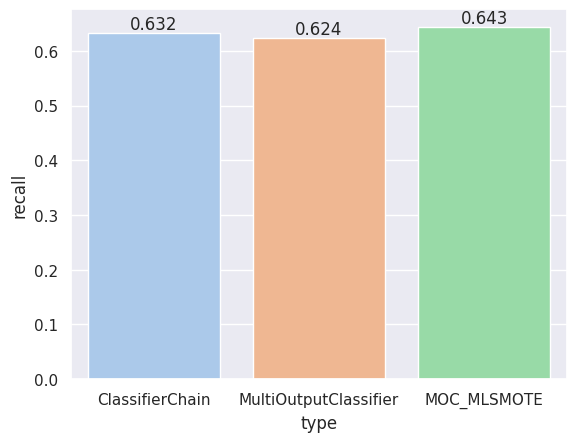

In [91]:
ax = sns.barplot(data=means, x="type", y="recall")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

In [92]:
moc_results_2 = moc_results_2.to_frame().transpose()
moc_results_2['type'] = 'MultiOutputClassifier'

cc_results_2 = cc_results_2.to_frame().transpose()
cc_results_2['type'] = 'ClassifierChain'

mlsmote_results_2 = mlsmote_results_2.to_frame().transpose()
mlsmote_results_2['type'] = 'MOC_MLSMOTE'

results_2 = pd.concat([cc_results_2, moc_results_2, mlsmote_results_2])
results_2.head()

hamming_loss  accuracy  f1_macro                   type
0      0.079175  0.674984  0.681789        ClassifierChain
0      0.080420  0.649078  0.674816  MultiOutputClassifier
0      0.081135  0.645423  0.688018            MOC_MLSMOTE

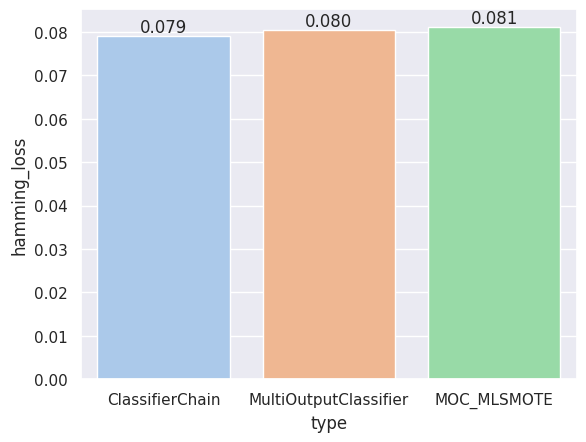

In [93]:
ax = sns.barplot(data=results_2, x='type', y="hamming_loss")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

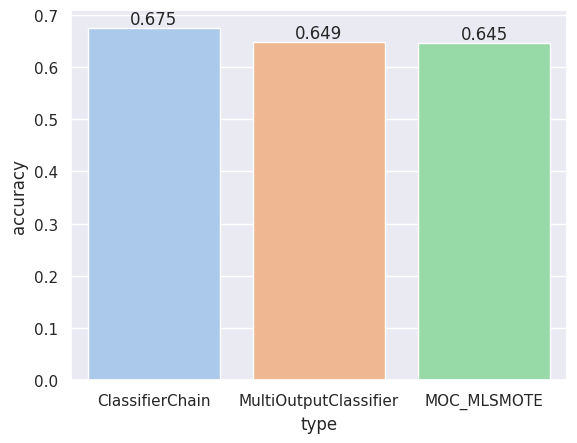

In [94]:
ax = sns.barplot(data=results_2, x='type', y="accuracy")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

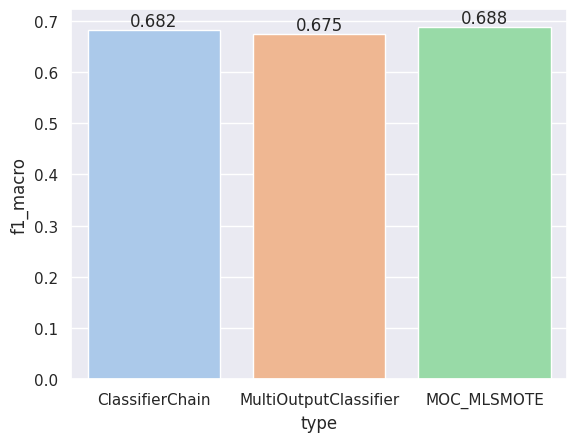

In [95]:
ax = sns.barplot(data=results_2, x='type', y="f1_macro")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')